# TP 2: Déquantification d'image par régularisation $H^1$


Dans ce TP, nous allons considérer une méthode d'optimisation pour
dé-quantifier des images. Pour $\tau>0$, nous considèrerons la quantification
d'une image $u\in{\mathbb R}^{N^2}$ définie par l'image $v\in{\mathbb R}^{N^2}$, de
coordonnées :
$$v_{i,j}=q_\tau(u_{i,j}),
$$
pour $(i,j)\in\{0,\ldots , N-1\}^2$ avec pour tout $t\in{\mathbb R}$,
$$q_\tau(t)=\tau \left[\frac{t}{\tau}+\frac{1}{2}\right]
$$
où $[x]$ représente la partie entière de $x$ (i.e.: le plus grand entier plus
petit que $x$). On note $Q$, l'opérateur de quantification et on a donc
$$v=Q(u).
$$

Ainsi, on a perdu des niveaux de gris, le résultat $v$ présente de larges
zones où sa valeur est constante. Ce qui n'est pas agréable à voir. 

Comme dans le TP précédent, on note
$${\mathcal C}=\{w\in{\mathbb R}^{N^2}, Q(w)=v\}
$$

Nous proposons donc le problème d'optimisation consistant à 
$$(P):\left\{\begin{array}{l}
\mbox{minimiser } E(w) \\ 
\mbox{sous la contrainte } w\in\overline{{\mathcal C}},
\end{array}\right.
$$
pour une énergie $E$ bien choisie ($\overline{{\mathcal C}}$ d\'esigne la fermeture de
${\mathcal C}$).

Nous considèrerons dans ce TP la minimisation de l'énergie définie par
$$E(w)=\sum_{i,j=0}^{N-1} |\nabla w_{i,j}|^2
$$
pour $w\in {\mathbb R}^{N^2}$, avec
$$\nabla w_{i,j}=\left(\begin{array}{c}
(D_x w)_{i,j} \\
(D_y w)_{i,j}
\end{array}
\right)=\left(\begin{array}{c}
w_{i+1,j}-w_{i,j} \\
w_{i,j+1}-w_{i,j}
\end{array}
\right)
$$
pour $(i,j)\in\{0,\ldots,N-1\}^2$ (on supposera que $w$ est périodisée en
dehors de son support).



## Chargement de bibliothèques, chargement d'une image et affichage d'une image

In [1]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2




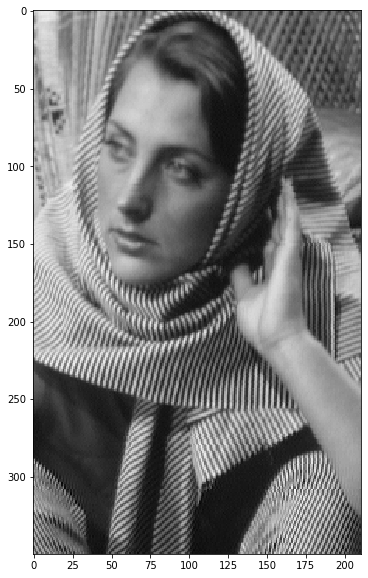

In [2]:
u = 255 * mpimg.imread("barbara.png")
u = u[0:350,300:511]    # image de taille moyenne
#u = u[100:140,300:331]   # Toute petite image pour debugger

plt.figure(figsize = (10,10))
plt.imshow(u,cmap='gray')
plt.show()

## Fonction calculant la quantification

In [3]:
def quantifie_image(u,tau):

    return tau * np.around(u/tau)

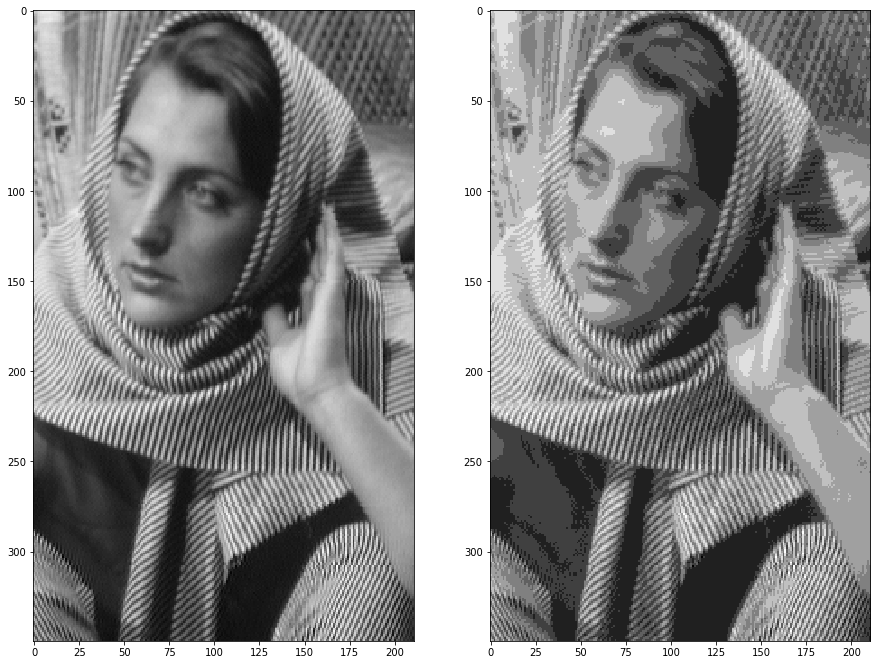

In [4]:
tau=30
v = quantifie_image(u,tau)

plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(u,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(v,cmap='gray')



## Fonction calculant itérativement le minimiseur

In [5]:
def grad_x(img, adjoint):

    sx , sy = np.shape(img)
    tmp=np.zeros(img.shape)
    if adjoint==0:
        tmp[-1]=img[0]
        tmp[:-1]=img[1:]
    else:
        tmp[0]=img[-1]
        tmp[1:]=img[:-1]
    return tmp-img

def verifie_grad_x(in1,in2):
    tmp1 = sum(sum(grad_x(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_x(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    return tmp1==tmp2
    
def grad_y(img, adjoint):
    tmp=np.zeros(img.shape)
    if adjoint==0:
        tmp[:,-1]=img[:,0]
        tmp[:,:-1]=img[:,1:]
    else:
        tmp[:,0]=img[:,-1]
        tmp[:,1:]=img[:,:-1]
    return tmp-img

def verifie_grad_y(in1,in2):
    tmp1 = sum(sum(grad_y(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_y(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
################################
def phi(img,tau):
    tmp = np.abs( np.copy(img))-tau/2
    
    return tmp * tmp * (tmp>0)

def phi_p(img,tau):
    dom = (np.abs(img)-tau/2 ) >0
    
    return (2*img - np.sign(img)*tau)*dom

def grad_E(out,v,tau,Lambda):
    tmpx = grad_x(out,0)
    tmpx1 = grad_x(tmpx,1)
    tmpy = grad_y(out,0)
    tmpy1 = grad_y(tmpy,1)
    
    grad = 2 * (tmpx1 + tmpy1) + Lambda * phi_p(out-v,tau)
    
    return grad

def E(out,v,tau,Lambda):
    sx , sy = np.shape(out)
    gx = np.linalg.norm( grad_x(out,0), ord='fro')
    gy = np.linalg.norm( grad_y(out,0), ord='fro')
    data = np.linalg.norm( phi(out - v,tau) , ord='fro')
    
    return (gx*gx + gy*gy + Lambda *data)/(sx*sy)

def deQuantifie(v,tau,Lambda,nbIter):
    pas = 1/(8+2*Lambda)
    v = quantifie_image(v,tau)

    out = np.copy(v)                # initialisation proche de la solution
#    out = np.zeros(np.shape(v))    # initialisation plus lointaine (pour tester)

    for it in range(nbIter):
        d = grad_E(out,v,tau,Lambda)
        out = out - pas * d
        print( 'iter = ', it , 'fonction = ', E(out,v,tau,Lambda) ,\
              'max contrainte = ', (np.abs(out-v)-(tau/2)).max() ,\
              'H1 = ', E(out,v,tau,0) , \
              'norm grad =', np.linalg.norm(d) )
        
    return out

iter =  0 fonction =  297.7932864864399 max contrainte =  86.0 H1 =  297.02369668246445 norm grad = 33670.449952443465
iter =  1 fonction =  167.2047038607429 max contrainte =  69.6 H1 =  166.2507331076506 norm grad = 11298.055761944177
iter =  2 fonction =  127.04379072666809 max contrainte =  77.6 H1 =  125.92068913744077 norm grad = 5162.297039109624
iter =  3 fonction =  114.57770394636428 max contrainte =  71.824 H1 =  113.43057513727825 norm grad = 3021.288727414181
iter =  4 fonction =  106.20358460064196 max contrainte =  73.3792 H1 =  105.01799386964062 norm grad = 2047.0647241902245
iter =  5 fonction =  102.59475293366287 max contrainte =  72.60288 H1 =  101.40565117121291 norm grad = 1502.0431043103922
iter =  6 fonction =  99.34015721000124 max contrainte =  72.633088 H1 =  98.13761518175298 norm grad = 1160.8111570537671
iter =  7 fonction =  97.61168723085893 max contrainte =  73.0079232 H1 =  96.40765858321615 norm grad = 931.5116589178554
iter =  8 fonction =  95.93781

iter =  66 fonction =  88.81246043314863 max contrainte =  73.28373323672609 H1 =  87.59119419320612 norm grad = 41.628834215557184
iter =  67 fonction =  88.8075344897127 max contrainte =  73.28373239229977 H1 =  87.58626702741667 norm grad = 40.71884405945022
iter =  68 fonction =  88.80282893203974 max contrainte =  73.2837317130778 H1 =  87.58156029455084 norm grad = 39.842831062258554
iter =  69 fonction =  88.79833127272279 max contrainte =  73.28373110789583 H1 =  87.57706150535698 norm grad = 38.998697636770984
iter =  70 fonction =  88.79402967244587 max contrainte =  73.28373061500469 H1 =  87.57275881830195 norm grad = 38.185477504657776
iter =  71 fonction =  88.78991344865906 max contrainte =  73.28373017750062 H1 =  87.56864154902269 norm grad = 37.40193995689643
iter =  72 fonction =  88.78597254834587 max contrainte =  73.28372981695647 H1 =  87.5646996425725 norm grad = 36.64195503421832
iter =  73 fonction =  88.7821980309527 max contrainte =  73.28372949772935 H1 =  

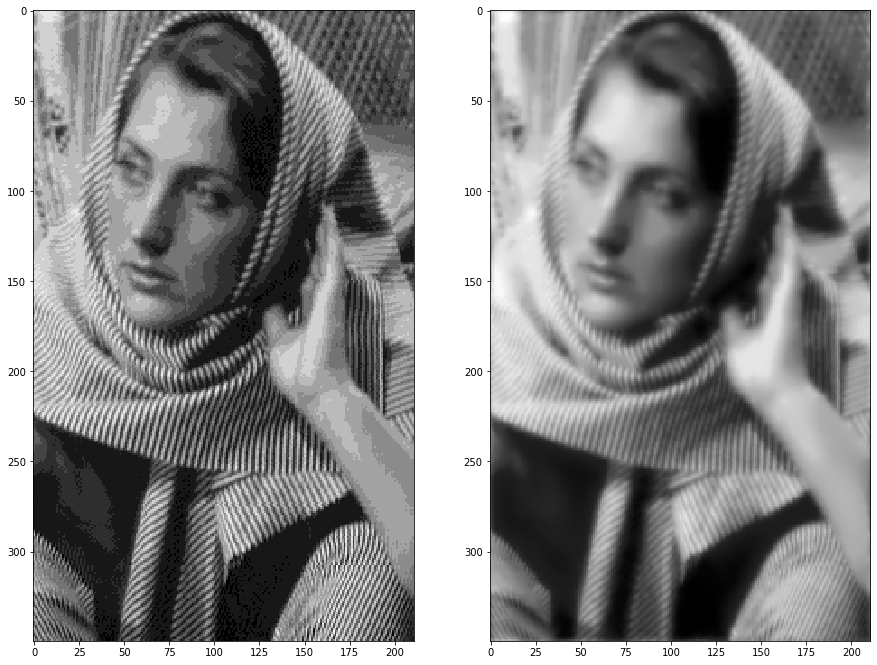

In [7]:
tau = 20
v = quantifie_image(u,tau)
Lambda=1
out = deQuantifie(v,tau,Lambda,100)


plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(v,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out,cmap='gray')